In [2]:
import keras 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
import importlib
import generators
importlib.reload(generators)

<module 'generators' from '/home/faster/Documents/approximating_shefem/generators.py'>

In [3]:
era5_train_path = "/home/faster/Documents/approximating_shefem/ERA5_adriatic_u10v10sp_2010-2018.npy"
era5_test_path = "/home/faster/Documents/approximating_shefem/era5_years/ERA5_adriatic_u10v10sp_2019.npy"
vhrea_train_path = "/home/faster/Documents/approximating_shefem/VHR-REA-reprojected_and_strict_cut_mslp-u10-v10_2010-2018.npy"
vhrea_test_path = "/home/faster/Documents/approximating_shefem/VHR-REA-reprojected_and_strict_cut_mslp-u10-v10_2019.npy"
target_image_train_path = "/home/faster/Documents/approximating_shefem/processed_data/target_images_2010-2018.npy"
target_image_test_path = "/home/faster/Documents/approximating_shefem/processed_data/2019_images.npy"
ephem_train_path = "/home/faster/Documents/approximating_shefem/dist_alt_az_moon-sun_coord13-45_2010-2018_norm.npy"
ephem_test_path = "dist_alt_az_moon-sun_coord13-45_2019_norm.npy"

In [4]:
train_generator = generators.DataGeneratorMemmap(era5_train_path, vhrea_train_path, target_image_train_path,ephem_train_path, 78888, sequential=False, batch_size=8, vhrrea_flag = False)
test_generator_random = generators.DataGeneratorMemmap(era5_test_path, vhrea_test_path, target_image_test_path, ephem_test_path, 8760, sequential=False, batch_size=8, vhrrea_flag = False)
test_generator = generators.DataGeneratorMemmap(era5_test_path, vhrea_test_path, target_image_test_path, ephem_test_path, 8760, sequential=True, batch_size=8, vhrrea_flag = False)

In [5]:
(a,e),b = train_generator.__getitem__(1)

In [6]:
def plot_images(array):

    fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(20, 2)) # Adjust figsize as needed
    
    for i in range(12):
        ax = axes[i]
        ax.imshow(array[:, :, i], cmap='viridis') # Use cmap='gray' for grayscale images
        ax.axis('off') # Hide axes for a cleaner look

    plt.tight_layout()
    plt.show()

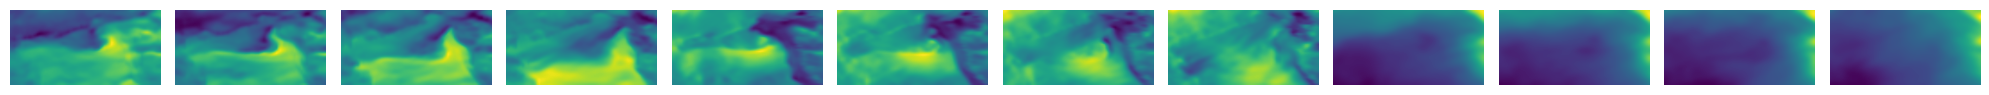

In [7]:
plot_images(a[0])

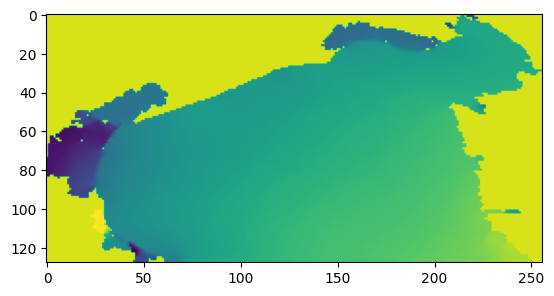

In [8]:
plt.imshow(b[5])

In [9]:
from keras import layers
from keras import Model
def build_unet():

        def ResidualBlock(width):
            def apply(x):
                input_width = x.shape[3]
                if input_width == width:
                    residual = x
                else:
                    residual = layers.Conv2D(width, kernel_size=1)(x)
                #x = layers.BatchNormalization(center=False, scale=False)(x)
                x = layers.LayerNormalization(axis=-1,center=True, scale=True)(x)
                x = layers.Conv2D(
                    width, kernel_size=3, padding="same", activation=keras.activations.swish
                )(x)
                x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
                x = layers.Add()([x, residual])
                return x
        
            return apply

        
        def DownBlock(width, block_depth):
            def apply(x):
                x, skips = x
                for _ in range(block_depth):
                    x = ResidualBlock(width)(x)
                    skips.append(x)
                x = layers.AveragePooling2D(pool_size=2)(x)
                return x
            return apply
        
        
        def UpBlock(width, block_depth):
            def apply(x):
                x, skips = x
                x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
                for _ in range(block_depth):
                    x = layers.Concatenate()([x, skips.pop()])
                    x = ResidualBlock(width)(x)
                return x
            return apply
        
        #widths = [64,128,256]
        block_depth = 3
        
        #x = Input(shape=self.lr_shape)
        
        input_a = keras.Input(shape=(128,256,12))

        input_b = keras.Input((6,))
        dense = keras.layers.Dense(512,activation = "relu")(input_b)
        reshape = keras.layers.Reshape((16,32,1))(dense)
        #up = keras.layers.Conv2DTranspose(30,(3,3),strides=(2,2),padding="same",activation="relu")(reshape)
        up = keras.layers.Conv2DTranspose(30,(3,3),strides=(2,2),padding="same",activation="relu")(reshape)
        up = keras.layers.Conv2DTranspose(10,(3,3),strides=(2,2),padding="same",activation="relu")(up)
        up = keras.layers.Conv2DTranspose(10,(3,3),strides=(2,2),padding="same",activation="relu")(up)
        up = layers.Conv2D(10, kernel_size=3,activation="relu", padding="same")(up)
        up = layers.Conv2D(3, kernel_size=3,activation="relu", padding="same")(up)
        
        a = layers.Concatenate()([input_a, up])
        #b = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        skips = []
        
        b = DownBlock(32, block_depth)([a, skips])
        b = DownBlock(64, block_depth)([b, skips])
        b = DownBlock(128, block_depth)([b, skips])
        b = DownBlock(256, block_depth)([b, skips])
    
        b = ResidualBlock(256)(b)
        b = ResidualBlock(256)(b)
        b = ResidualBlock(256)(b)

        b = UpBlock(256, block_depth)([b, skips])
        b = UpBlock(128, block_depth)([b, skips])
        b = UpBlock(64, block_depth)([b, skips])
        b = UpBlock(32, block_depth)([b, skips])
        
        output = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(b)
    
        return Model([input_a,input_b], output)

In [10]:
model = build_unet()

2024-03-26 16:59:06.125188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 16:59:06.137671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 16:59:06.137799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
optimizer = keras.optimizers.AdamW(learning_rate = 1e-4, weight_decay = 1e-5)

In [12]:
mask = np.load("/home/faster/Documents/approximating_shefem/sea_mask.npy")

In [13]:
mask = np.expand_dims(mask[:-2], axis = -1).astype(np.float32)

In [14]:
mask.dtype

dtype('float32')

In [15]:
from keras import ops

# def masked_loss(y_true, y_pred):
#     squared_difference = ops.square(y_true- ops.multiply(y_pred,mask))
#     return ops.mean(squared_difference, axis=-1) 

# def masked_loss2(y_true, y_pred, mask):
#     y_true_masked = ops.multiply(y_true, mask)
#     y_pred_masked = ops.multiply(y_pred, mask)
#     # Calculate squared difference using the masked values
#     squared_difference = ops.square(y_true_masked - y_pred_masked)

#     # Calculate the mean over all dimensions to get a scalar loss value
#     return ops.mean(squared_difference)

def masked_loss(y_true, y_pred):
    squared_difference = ops.square(y_true - y_pred)
    masked_squared_difference = ops.multiply(squared_difference, mask)
    return ops.mean(masked_squared_difference, axis = (1,2))

In [16]:
model.compile(optimizer=optimizer, loss=masked_loss)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6)         │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 512)       │   3,584 │ input_layer_1[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ reshape (Reshape)   │ (None, 16, 32, 1) │       0 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose    │ (None, 32, 64,    │     300 │ reshape[0][0]        │
│ (Conv2DTranspose)   │ 30)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose_1  │ (None, 64, 128,   │   2,710 │ conv2d_transpose[0]… │
│ (Conv2DTranspose)   │ 10)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose_2  │ (None, 128, 256,  │     910 │ conv2d_transpose_1[… │
│ (Conv2DTranspose)   │ 10)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │     910 │ conv2d_transpose_2[… │
│                     │ 10)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_layer         │ (None, 128, 256,  │       0 │ -                    │
│ (InputLayer)        │ 12)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │     273 │ conv2d[0][0]         │
│                     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 128, 256,  │       0 │ input_layer[0][0],   │
│ (Concatenate)       │ 15)               │         │ conv2d_1[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ layer_normalization │ (None, 128, 256,  │      30 │ concatenate[0][0]    │
│ (LayerNormalizatio… │ 15)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │   4,352 │ layer_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 256,  │   9,248 │ conv2d_3[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │     512 │ concatenate[0][0]    │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add (Add)           │ (None, 128, 256,  │       0 │ conv2d_4[0][0],      │
│                     │ 32)               │         │ conv2d_2[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ layer_normalizatio… │ (None, 128, 256,  │      64 │ add[0][0]            │
│ (LayerNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 256,  │   9,248 │ layer_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼────────────────────

 Total params: 15,706,222 (59.91 MB)

 Trainable params: 15,706,222 (59.91 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import Callback

class VisualizeCallback(Callback):
    def __init__(self, output_dir='ephem_output_images_vhr2'):
        super(VisualizeCallback, self).__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        if(epoch % 2 == 0):
            # Unpack the test data
            (a,e), b = test_generator_random.__getitem__(1)
            # Make predictions
            preds = model.predict((a,e), verbose = 0)
            
            # Plotting
            n = 4  # Number of images to display
            plt.figure(figsize=(12, 9))
    
            loss = masked_loss(b, preds)
            loss = loss.numpy()
            
            for i in range(n):
                # Display true image
                ax = plt.subplot(5, n, i + 1)
                plt.imshow(b[i]*mask)
                plt.colorbar()
                plt.title("True, loss: "+ str(np.round(loss[i],6)))
                plt.axis("off")
                
                # Plot predicted image (first time)
                ax = plt.subplot(5, n, i + 1 + n)
                plt.imshow(preds[i]*mask)
                plt.colorbar()
                plt.title("Pred mask")
                plt.axis("off")

                # Plot predicted image (second time)
                ax = plt.subplot(5, n, i + 1 + 2*n)
                plt.imshow(preds[i])
                plt.colorbar()
                plt.title("Pred no mask")
                plt.axis("off")
                
                # Plot predicted image (second time)
                ax = plt.subplot(5, n, i + 1 + 3*n)
                plt.imshow(b[i]*mask, vmin=0, vmax=1, cmap = "turbo")
                plt.colorbar()
                plt.title("true eq norm")
                plt.axis("off")

                # Plot predicted image (second time)
                ax = plt.subplot(5, n, i + 1 + 4*n)
                plt.imshow(preds[i]*mask, vmin=0, vmax=1, cmap = "turbo")
                plt.colorbar()
                plt.title("Pred mask eq norm")
                plt.axis("off")
            
            plt.tight_layout()
            
            # Generate a unique filename for each epoch
            filename = f'{self.output_dir}/comparison_epoch_{epoch+1}.png'
            plt.savefig(filename)
            
            plt.close() 
        if(epoch % 10 == 0):
            model.save_weights("weights/epoch"+str(epoch)+"ephemVHR2.weights.h5")

In [19]:
visualize_callback = VisualizeCallback()
# for i in range(310,320):
visualize_callback.on_epoch_end(20)

2024-03-26 16:59:08.070746: I external/local_xla/xla/service/service.cc:168] XLA service 0x2a4acb20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-26 16:59:08.070769: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-03-26 16:59:08.116749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-26 16:59:09.022901: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-26 16:59:09.524902: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1711468753.746050   78642 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [20]:
#model.load_weights("weights/epoch160ephemVHR.weights.h5")

In [ ]:
history = model.fit(
    train_generator,
    validation_data = test_generator_random,
    validation_steps = 100,
    validation_freq = 2,
    steps_per_epoch = 1000,
    initial_epoch = 0,
    epochs = 160,
    callbacks=[visualize_callback]
)

Epoch 1/160


/home/faster/anaconda3/envs/keras3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 172s 130ms/step - loss: 0.0145
Epoch 2/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 138s 138ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 3/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 132s 132ms/step - loss: 0.0095
Epoch 4/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 136s 136ms/step - loss: 0.0091 - val_loss: 0.0106
Epoch 5/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 132s 132ms/step - loss: 0.0095
Epoch 6/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0091 - val_loss: 0.0106
Epoch 7/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0095
Epoch 8/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 136s 136ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 9/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0093
Epoch 10/160
 861/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.0095

/home/faster/anaconda3/envs/keras3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 118s 118ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 11/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0091
Epoch 12/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 13/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0086
Epoch 14/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 15/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0092
Epoch 16/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 17/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - loss: 0.0080
Epoch 18/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 19/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - loss: 0.0051
Epoch 20/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 119s 119ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 21/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - loss: 0.0038

2024-03-26 17:48:46.831270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3637320349939212624
2024-03-26 17:48:46.831291: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16442072414724709100
2024-03-26 17:48:46.831297: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9682103259817803556


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0031
Epoch 24/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 25/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0033
Epoch 26/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 27/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 133s 133ms/step - loss: 0.0029
Epoch 28/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 29/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - loss: 0.0026
Epoch 30/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 119s 119ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 31/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - loss: 0.0026
Epoch 32/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 33/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - loss: 0.0027
Epoch 34/160
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - loss: 0.0027 - val_loss: 0.0035

In [ ]:
#model.save_weights("1st_test50epochs.weights.h5")

In [25]:
first_5_layers = model.layers[:9]

# The output of the last layer in the selection (5th layer)
output_of_5th_layer = first_5_layers[-1].output

# Create a new model that takes the original model's input and outputs the 5th layer's output
model_for_first_5_layers = Model(inputs=model.input, outputs=output_of_5th_layer)

# Now, you can use this model to execute the first 5 layers with the original weights
# For example, if you have some input data `input_data`
#output_of_first_5_layers = model_for_first_5_layers.predict(input_data)

In [26]:
model_for_first_5_layers.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6)         │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 512)       │   3,584 │ input_layer_1[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ reshape (Reshape)   │ (None, 16, 32, 1) │       0 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose    │ (None, 32, 64,    │     300 │ reshape[0][0]        │
│ (Conv2DTranspose)   │ 30)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose_1  │ (None, 64, 128,   │   2,710 │ conv2d_transpose[0]… │
│ (Conv2DTranspose)   │ 10)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_transpose_2  │ (None, 128, 256,  │     910 │ conv2d_transpose_1[… │
│ (Conv2DTranspose)   │ 10)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │     910 │ conv2d_transpose_2[… │
│                     │ 10)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_layer         │ (None, 128, 256,  │       0 │ -                    │
│ (InputLayer)        │ 12)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │     273 │ conv2d[0][0]         │
│                     │ 3)                │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 8,687 (33.93 KB)

 Trainable params: 8,687 (33.93 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
(a,e),b = train_generator.__getitem__(1)

In [45]:
output = model_for_first_5_layers((a,e))

In [46]:
output.shape

TensorShape([8, 128, 256, 3])

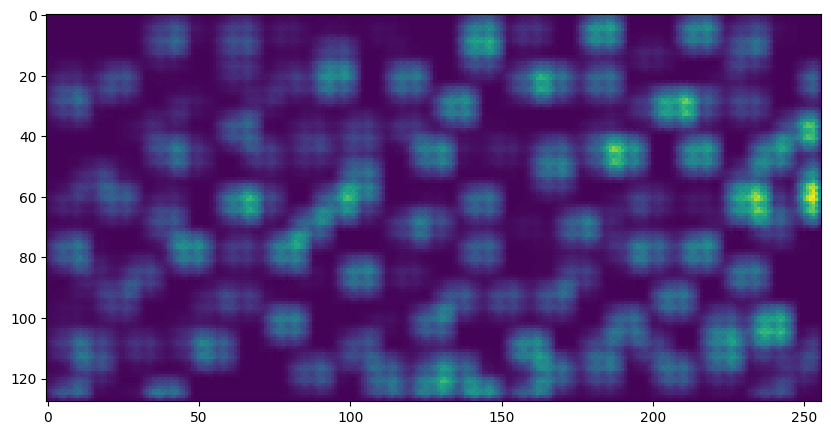

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,:,:,0])
#plt.imsave("/home/faster/Desktop/learned_embedding.png",output[0,:,:,0])

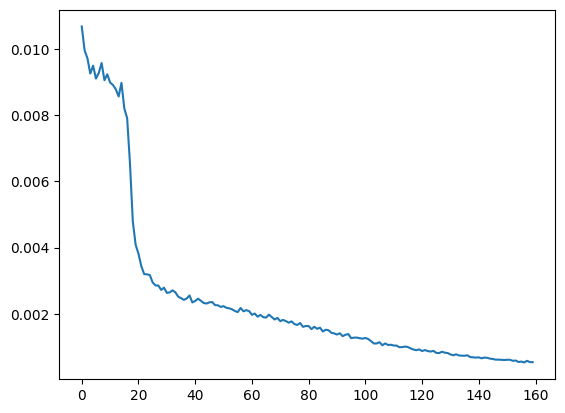

In [51]:
plt.plot(history.history["loss"])

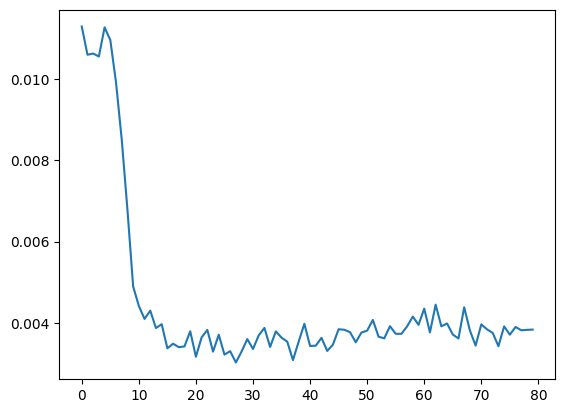

In [52]:
plt.plot(history.history["val_loss"])

In [146]:
(a,e), b = train_generator.__getitem__(1)
c = model.predict((a,e), verbose = 0)

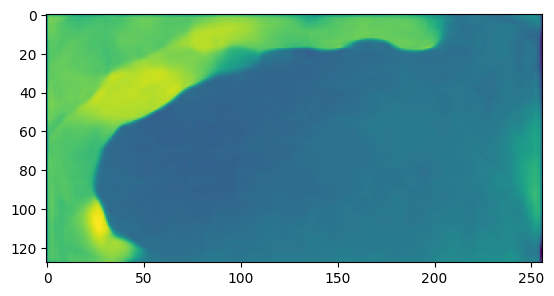

In [154]:
i = 7
plt.imshow(c[i,:,:,0])
plt.imsave("output"+str(i)+".png",c[i,:,:,0])

In [56]:
b[0].min()

0.29711882895915376

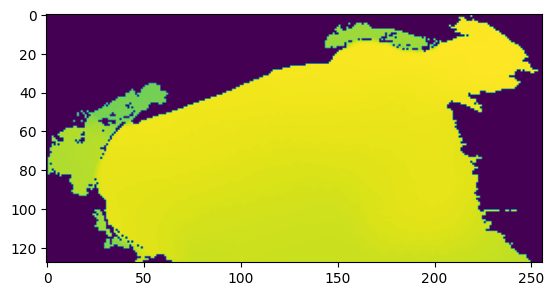

In [57]:
plt.imshow(b[0] * mask)

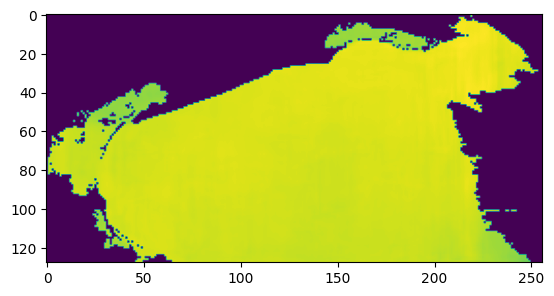

In [58]:
plt.imshow(c[0] * mask)

In [145]:
test_generator = generators.DataGeneratorMemmap(era5_test_path, vhrea_test_path, target_image_test_path, ephem_test_path, 8760, sequential=True, batch_size=32, vhrrea_flag = True)
model.load_weights("weights/epoch150ephemVHR2.weights.h5")

In [79]:
test_generator.__len__()

274

In [80]:
losses = []
test_generator.counter_reset()

for i in range(test_generator.__len__() - 1):
    if(i % 10 == 0):
        print(i)
    (a,e), b = test_generator.__getitem__(1)
    c = model.predict((a,e), verbose = 0)

    loss = masked_loss(b, c)
    loss = loss.numpy()
    losses.append(loss.mean()) 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270


In [77]:
np.array(losses).mean()

0.0036756833053066306

In [81]:
np.array(losses).mean()

0.00357064267056875

In [92]:
np.array(losses).mean()

0.003685151430232025

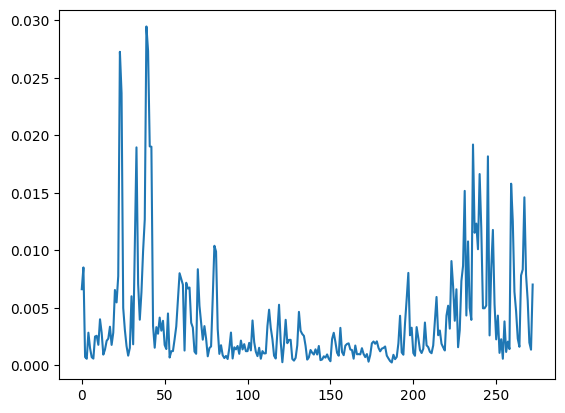

In [65]:
plt.plot(losses)

### Extras

In [ ]:
test_generator.counter_reset()
max = 0.5
min = 0.5
for i in range(1000):
    print(i)
    a,b = test_generator.__getitem__(1)
    if(a[:,:,:,8:].max() > max):
        max = a[:,:,:,8:].max()
    if(a[:,:,:,8:].min() < min):
        min = a[:,:,:,8:].min()        
    

In [ ]:
def normalize_array(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr